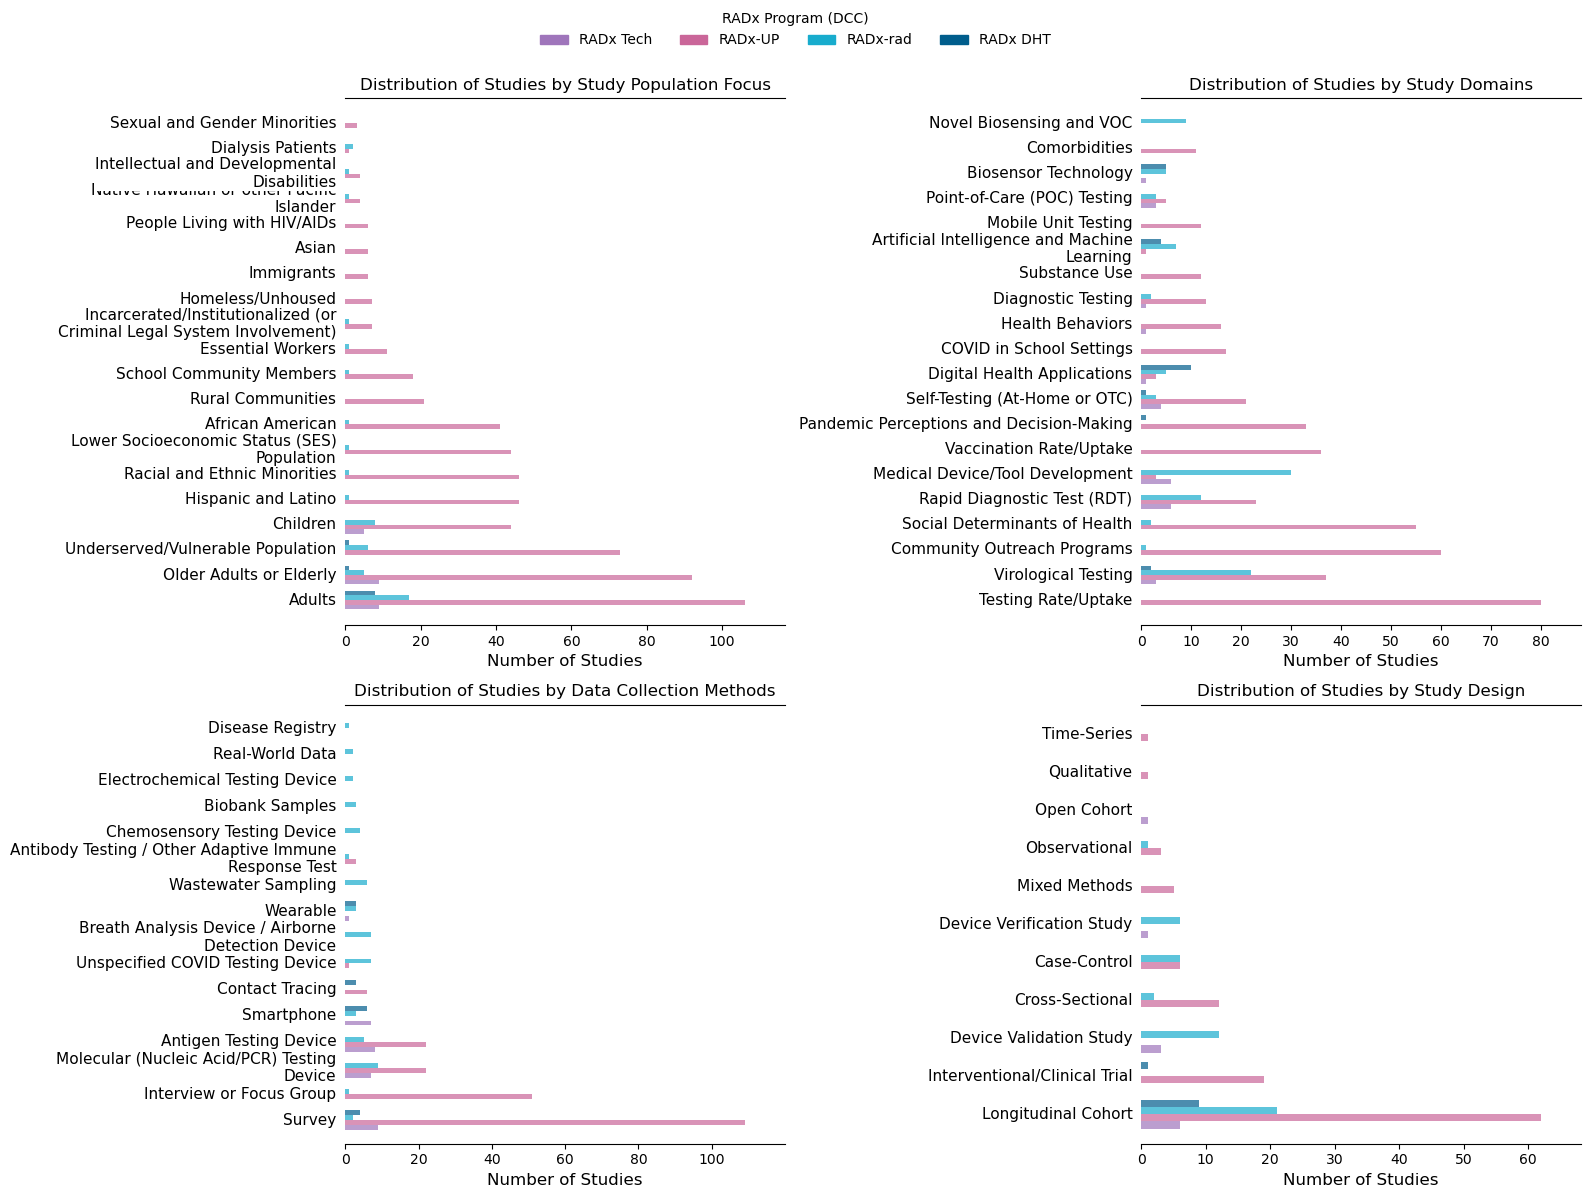

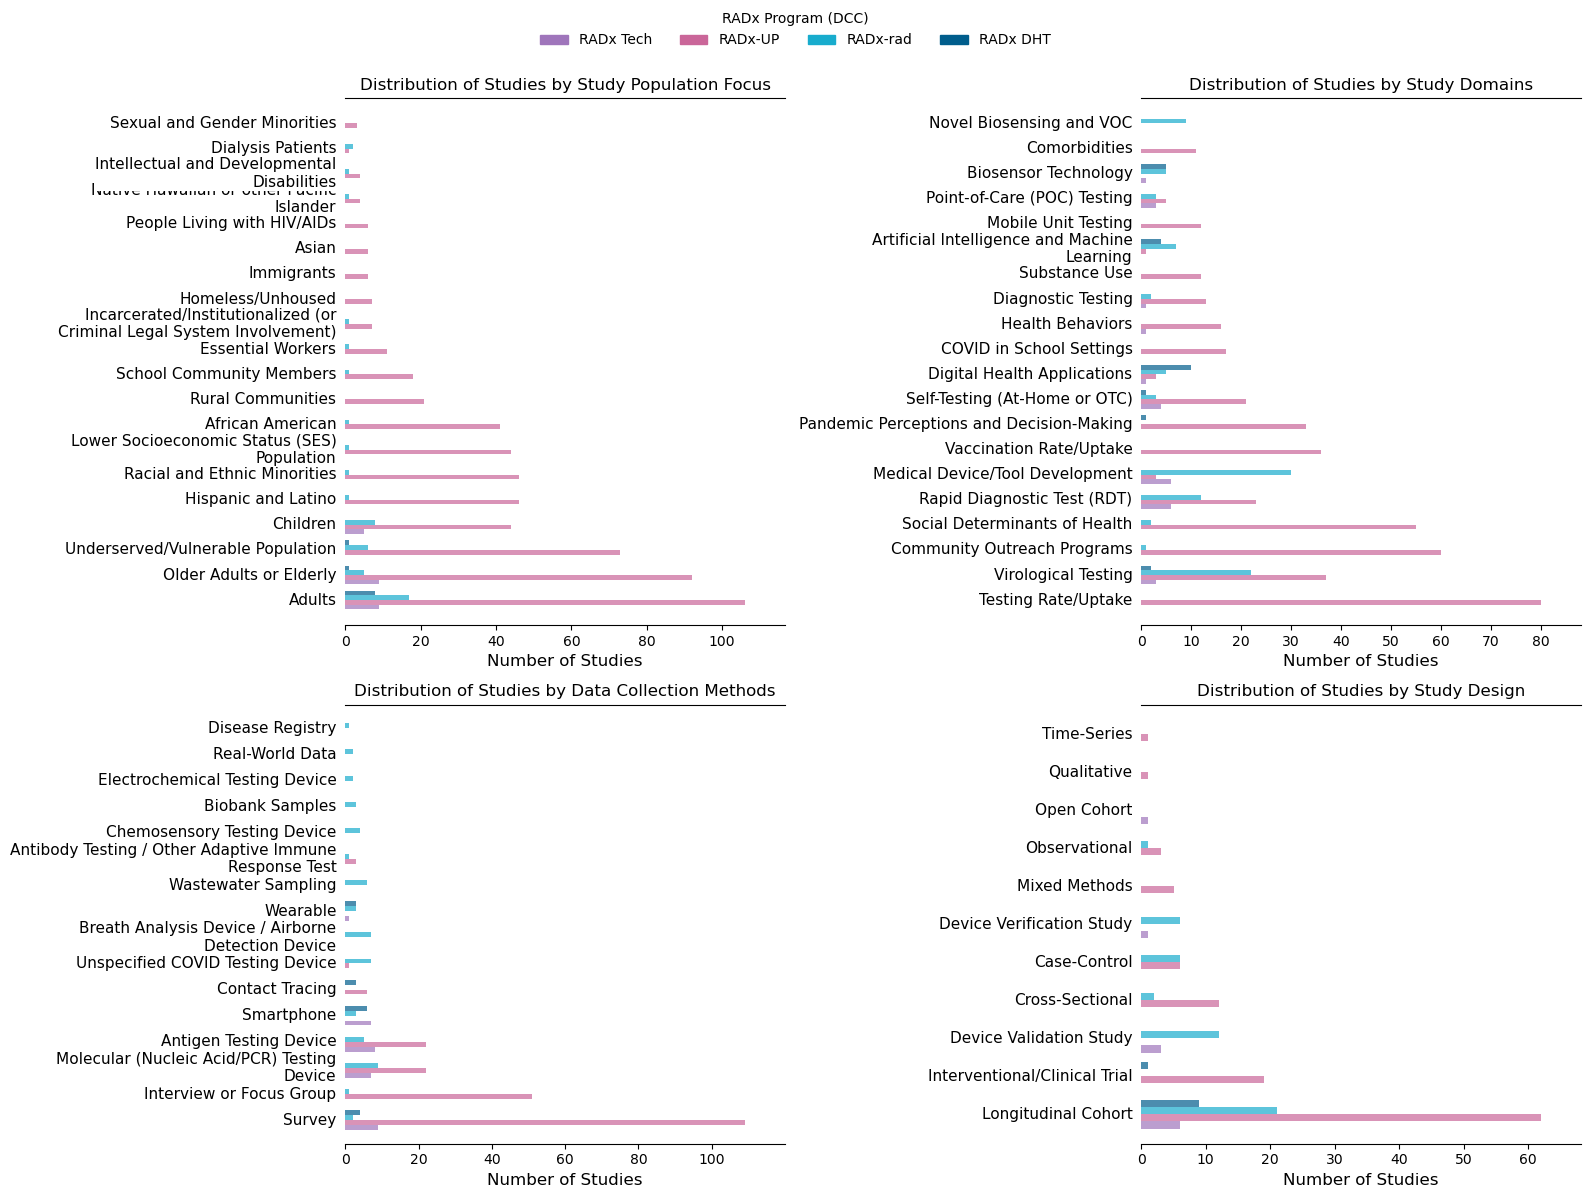

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import textwrap

# -------------------------------
# 1. Load and Preprocess the Data
# -------------------------------

def load_and_preprocess_data(file_path):
    """
    Load data from the CSV file and preprocess it by splitting specified columns.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: Preprocessed DataFrame.
    """
    data = pd.read_csv(file_path, encoding="latin1")
    columns_to_split = ["Study Population Focus", "Study Domain", "Data Collection Method"]

    for column in columns_to_split:
        data[column] = data[column].str.split("; ")

    return data

# -------------------------------
# 2. Prepare Data for Visualization
# -------------------------------

def get_top_categories(data, column_name, top_n=20):
    """
    Get the top N categories based on frequency in the specified column.

    Args:
        data (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The column to analyze.
        top_n (int): Number of top categories to return.

    Returns:
        pd.Index: Index of the top N categories.
    """
    exploded_data = data.explode(column_name)
    top_categories = exploded_data[column_name].value_counts().head(top_n).index
    return top_categories

def prepare_overlapping_data(data, column_name, top_categories):
    """
    Prepare a DataFrame for overlapping bar plotting, sorted by total number of studies.

    Args:
        data (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The column to analyze.
        top_categories (pd.Index): The top categories to include.

    Returns:
        dict: Dictionary with RADx Programs as keys and DataFrames as values.
        list: Sorted list of all categories.
    """
    exploded_data = data.explode(column_name)
    filtered_data = exploded_data[exploded_data[column_name].isin(top_categories)]
    grouped_data = filtered_data.groupby(["RADx Data Program", column_name]).size().unstack(fill_value=0)

    # Sum counts across RADx Programs to get total studies per category
    total_counts = grouped_data.sum(axis=0)

    # Sort categories based on total counts in descending order
    sorted_categories = total_counts.sort_values(ascending=False).index.tolist()

    # Reindex grouped_data to include all categories and sort them
    all_categories = sorted_categories
    overlapping_data = {}
    for program in grouped_data.index:
        program_data = grouped_data.loc[program]
        program_data = program_data.reindex(all_categories, fill_value=0)
        overlapping_data[program] = program_data

    return overlapping_data, all_categories

# -------------------------------
# 3. Plotting Function
# -------------------------------

def plot_overlapping_bars_horizontal(data_list, category_lists, titles, xlabel, colors, output_file):
    """
    Plot horizontal overlapping bar charts with labels wrapped and adjusted to prevent overlap.

    Args:
        data_list (list): List of dictionaries containing data for each RADx Program.
        category_lists (list): List of sorted categories for each subplot.
        titles (list): Titles for each subplot.
        xlabel (str): Label for the x-axis.
        colors (dict): Dictionary mapping RADx Programs to colors.
        output_file (str): File name to save the plot.
    """
    fig = plt.figure(figsize=(16, 12))
    gs = GridSpec(2, 2, height_ratios=[1.2, 1])

    # Create subplots
    axes = []
    axes.append(fig.add_subplot(gs[0, 0]))
    axes.append(fig.add_subplot(gs[0, 1]))
    axes.append(fig.add_subplot(gs[1, 0]))
    axes.append(fig.add_subplot(gs[1, 1]))

    # Adjust the plot margins
    plt.subplots_adjust(left=0.4, right=0.95, top=0.92, bottom=0.08, hspace=0.6)

    # RADx Programs
    radx_programs = list(colors.keys())
    num_programs = len(radx_programs)
    bar_height = 0.6  # Height of each bar
    bar_spacing = 0.2  # Spacing between bars
    opacity = 0.7  # Transparency for overlapping bars

    for i, (data_dict, all_categories) in enumerate(zip(data_list, category_lists)):
        ax = axes[i]

        # Wrap labels and calculate line counts
        wrapped_labels = []
        label_line_counts = []
        for label in all_categories:
            if len(label) > 40:
                wrapped_label = textwrap.fill(label, width=40)
            else:
                wrapped_label = label
            num_lines = wrapped_label.count('\n') + 1
            wrapped_labels.append(wrapped_label)
            label_line_counts.append(num_lines)

        # Calculate y_positions dynamically
        y_positions = []
        current_y = 0
        line_height = 0.3  # Approximate height per line of text
        label_spacing = 0.2

        for num_lines in label_line_counts:
            total_label_height = num_lines * line_height
            total_height = max(bar_height, total_label_height) + label_spacing
            y_positions.append(current_y + total_height / 2)
            current_y += total_height

        total_chart_height = current_y

        # Prepare data for plotting
        for idx, program in enumerate(radx_programs):
            if program in data_dict:
                counts = data_dict[program].values
                # Adjust positions for overlapping bars
                offset = (idx - num_programs / 2 + 0.5) * (bar_height / num_programs)
                adjusted_y_positions = [y + offset for y in y_positions]

                ax.barh(
                    y=adjusted_y_positions,
                    width=counts,
                    height=bar_height / num_programs,
                    color=colors[program],
                    label=program,
                    alpha=opacity,
                    edgecolor='none'
                )

        # Set y-axis limits with padding
        padding = 0.025  # Padding as a fraction of the total chart height
        padding_value = total_chart_height * padding

        ax.set_ylim(
            -padding_value,
            total_chart_height + padding_value
        )

        # Hide y-ticks
        ax.set_yticks([])
        ax.set_yticklabels([])

        # Set x-axis limits starting from 0
        max_value = 0
        for program in data_dict:
            max_value = max(max_value, data_dict[program].max())
        ax.set_xlim(0, max_value * 1.1)

        # Add labels
        for y_pos, label in zip(y_positions, wrapped_labels):
            ax.text(
                x=-0.02, y=y_pos,
                s=label,
                ha='right', va='center',
                transform=ax.get_yaxis_transform(),
                fontsize=11,
                bbox=dict(facecolor='white', edgecolor='none', pad=0.5),
                clip_on=False,
            )

        ax.set_title(titles[i], fontsize=12)
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel("")

        # Optionally adjust spines and ticks
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='y', length=0)  # Remove y-axis ticks

    # Create custom legend
    legend_handles = [mpatches.Patch(color=colors[program], label=program) for program in radx_programs]
    fig.legend(
        handles=legend_handles,
        title="RADx Program (DCC)",
        loc='upper center',
        ncol=4,
        fontsize=10,
        frameon=False
    )

    # Adjust layout to include the legend and prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save and show the figure
    plt.savefig(output_file, format="png", dpi=300, bbox_inches='tight')
    plt.show()

# -------------------------------
# 4. Main Execution Flow
# -------------------------------

def main():
    # File path to the CSV data
    file_path = "StudyExplorerResults.csv"  # Replace with your actual file path

    # Load and preprocess data
    data = load_and_preprocess_data(file_path)

    # Define columns to analyze
    analysis_columns = [
        ("Study Population Focus", "Distribution of Studies by Study Population Focus"),
        ("Study Domain", "Distribution of Studies by Study Domains"),
        ("Data Collection Method", "Distribution of Studies by Data Collection Methods"),
        ("Study Design", "Distribution of Studies by Study Design"),
    ]

    # RADx Program colors
    radx_colors = {
        "RADx Tech": "#9f75bb",
        "RADx-UP": "#ca6699",
        "RADx-rad": "#18accd",
        "RADx DHT": "#005d8c",
    }

    # Prepare data and titles for plotting
    data_list = []
    category_lists = []
    titles = []
    for column_name, title in analysis_columns:
        top_categories = get_top_categories(data, column_name)
        overlapping_data, sorted_categories = prepare_overlapping_data(data, column_name, top_categories)
        data_list.append(overlapping_data)
        category_lists.append(sorted_categories)
        titles.append(title)

    xlabel = "Number of Studies"
    output_file = "overlapping_bars_horizontal_labels_sorted.png"

    # Plot all charts with horizontal bars and save to a file
    plot_overlapping_bars_horizontal(
        data_list=data_list,
        category_lists=category_lists,
        titles=titles,
        xlabel=xlabel,
        colors=radx_colors,
        output_file=output_file
    )

# Run the main function
if __name__ == "__main__":
    main()
